# Problem statement

Your task is to create Natural Language Inferencing (NLI) model that assigns labels of 0, 1, or 2, which corresponds to entailment, neutral, and contradiction, to pairs of premises and hypotheses. To make things more interesting, the train and test set were included in fifteen different languages!

# Preparation

In [1]:
# Import primary functions
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import secondary functions
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel

# Show the current version of TensorFlow
print(tf.__version__)

2.11.0


## Acquire files

In [2]:
# Get the files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


## Debug warnings

In [3]:
# Debug warnings
os.environ["WANDB_API_KEY"] = "0"

## Set up TPU

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Read files

In [5]:
train = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")
submission = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/sample_submission.csv")

In [6]:
train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [7]:
train.shape

(12120, 6)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [9]:
train.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [10]:
test

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


In [11]:
test.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64

In [12]:
submission

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,1
5192,1f0ea92118,1
5193,0407b48afb,1


# Analyze the train set

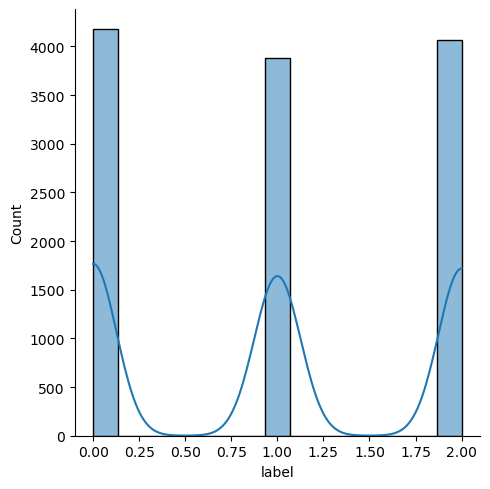

In [13]:
sns.displot(train['label'], kde=True)

In [14]:
train['label'].value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

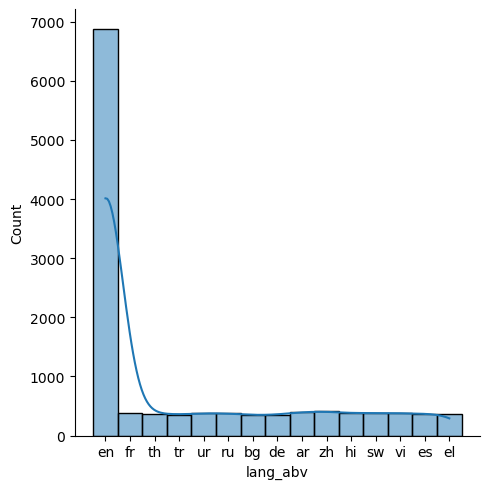

In [15]:
sns.displot(train['lang_abv'], kde=True)

# Analyze the test set

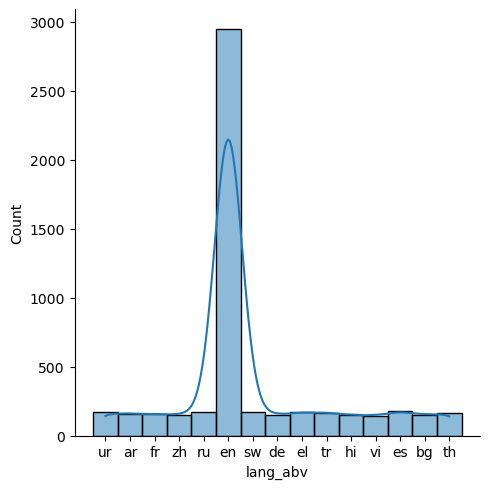

In [16]:
sns.displot(test['lang_abv'], kde=True)

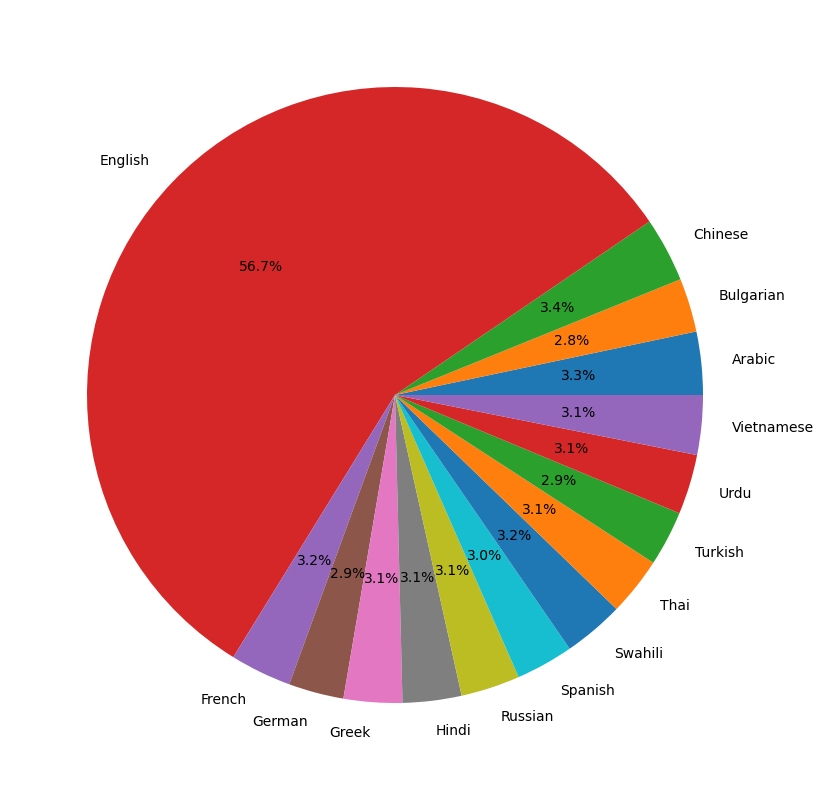

In [17]:
labels, frequencies = np.unique(train.language.values, return_counts = True)
plt.figure(figsize = (10, 10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

# Build model

In [18]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [19]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [20]:
encode_sentence("Machine learning is fun!")

[16840, 26901, 10124, 41807, 106, 102]

In [21]:
def bert_encode( premises,hypotheses,tokenizer):
    
    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([
        encode_sentence(s)
        for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
        encode_sentence(s)
        for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [22]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

# Define model

In [23]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
with strategy.scope():
    model = build_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

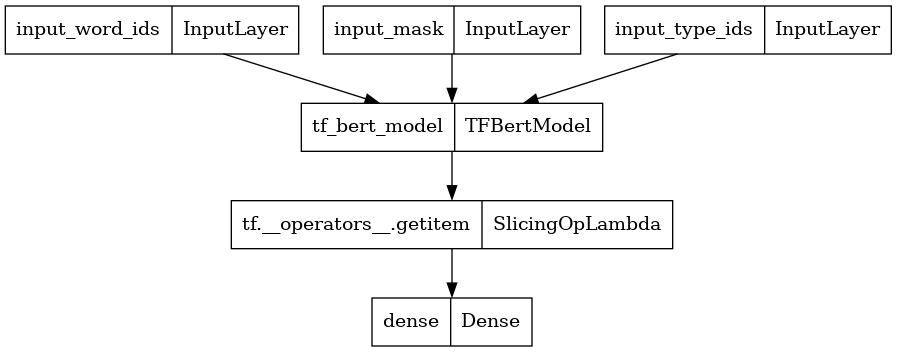

In [25]:
keras.utils.plot_model(model, "statement_classifier.png")

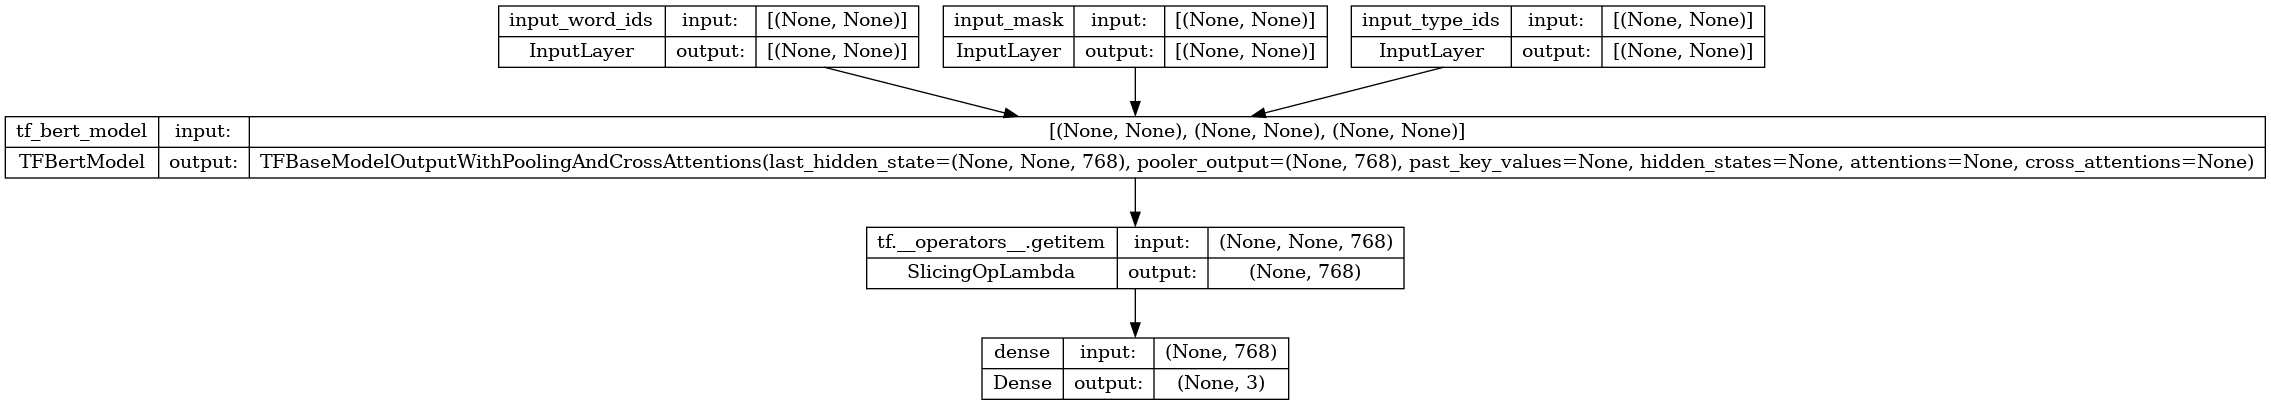

In [26]:
keras.utils.plot_model(model, "statement_classifier_with_shape_info.png", show_shapes=True)

In [27]:
model.fit(train_input, train.label.values, epochs = 5, verbose = 1, batch_size = 16, validation_split = 0.1)

Epoch 1/5
682/682 [==============================] - 653s 892ms/step - loss: 0.9374 - accuracy: 0.5405 - val_loss: 0.8105 - val_accuracy: 0.6155
Epoch 2/5
682/682 [==============================] - 606s 888ms/step - loss: 0.6944 - accuracy: 0.7043 - val_loss: 0.7899 - val_accuracy: 0.6749
Epoch 3/5
682/682 [==============================] - 605s 888ms/step - loss: 0.4888 - accuracy: 0.8047 - val_loss: 0.8263 - val_accuracy: 0.6766
Epoch 4/5
682/682 [==============================] - 606s 888ms/step - loss: 0.3159 - accuracy: 0.8788 - val_loss: 1.1112 - val_accuracy: 0.6823
Epoch 5/5
682/682 [==============================] - 605s 888ms/step - loss: 0.1970 - accuracy: 0.9283 - val_loss: 1.2195 - val_accuracy: 0.6749


# Evaluate model

In [28]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [29]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
predictions = np.array(predictions)
predictions = np.ndarray.flatten(predictions)
predictions

163/163 [==============================] - 86s 511ms/step


array([2, 1, 0, ..., 1, 0, 2])

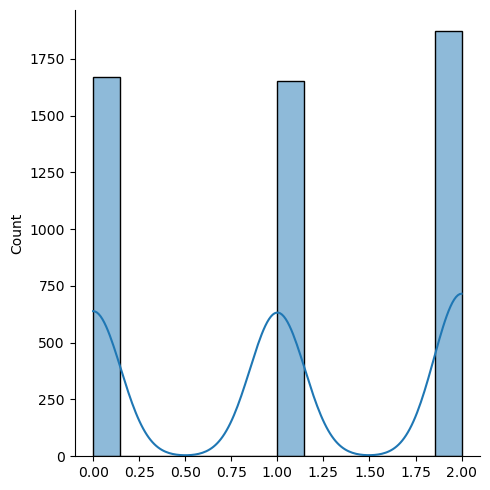

In [30]:
sns.displot(predictions, kde=True)

# Generate submission

In [31]:
# Generate a submission file
submission['prediction'] = predictions
submission.to_csv('submission.csv',index=False) # writing data to a CSV file
submission = pd.read_csv("submission.csv")
submission
print("Successfully saved as CSV file")

Successfully saved as CSV file
